# Import

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, normalize
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier, Pool, metrics, cv

import torch
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam

# Data preprocessing

## Dataset loading

In [2]:
df = pd.read_csv('train.csv')

X = df.drop(columns=['Transported'])
y = df['Transported'].astype(int)

print(f'X shape : {X.shape}')
X.head()

X shape : (8693, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [3]:
X_test = pd.read_csv('test.csv')

X_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Feature enginering

Based on the dataset informations, columns can be splitted to isolate more features per row.

In [4]:
def get_groupId(id):
    return id.split('_')[0]

def get_groupNumber(id):
    return id.split('_')[1]

def split_name(name):
    return name.split()[1]

def get_cabinDeck(cabin):
    return cabin.split('/')[0]
    
def get_cabinNum(cabin):
    return cabin.split('/')[1]
    
def get_cabinSide(cabin):
    return cabin.split('/')[2]

In [5]:
# get group id
X['GroupId'] = list(X['PassengerId'].apply(get_groupId))
X_test['GroupId'] = list(X_test['PassengerId'].apply(get_groupId))

# get group number
X['GroupNumber'] = list(X['PassengerId'].apply(get_groupNumber))
X_test['GroupNumber'] = list(X_test['PassengerId'].apply(get_groupNumber))

# get family name
X['FamilyName'] = X.loc[~X['Name'].isna(), 'Name'].apply(split_name)
X_test['FamilyName'] = X_test.loc[~X_test['Name'].isna(), 'Name'].apply(split_name)

# get cabin deck
X['CabinDeck'] = X.loc[~X['Cabin'].isna(), 'Cabin'].apply(get_cabinDeck)
X_test['CabinDeck'] = X_test.loc[~X_test['Cabin'].isna(), 'Cabin'].apply(get_cabinDeck)

# get cabin num
X['CabinNum'] = X.loc[~X['Cabin'].isna(), 'Cabin'].apply(get_cabinNum)
X_test['CabinNum'] = X_test.loc[~X_test['Cabin'].isna(), 'Cabin'].apply(get_cabinNum)

# get cabin side
X['CabinSide'] = X.loc[~X['Cabin'].isna(), 'Cabin'].apply(get_cabinSide)
X_test['CabinSide'] = X_test.loc[~X_test['Cabin'].isna(), 'Cabin'].apply(get_cabinSide)

## Analysis

In [6]:
X_train_info = pd.DataFrame(
    [X.dtypes, X.nunique(), X.nunique() / X.shape[0] * 100, X.isna().sum(), X.isna().sum() / X.shape[0] * 100], 
    index=['dtype', 'nunique', 'frac%_nunique', 'sum_na', '%_na'], 
    columns=X.columns
)

X_train_info

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,GroupId,GroupNumber,FamilyName,CabinDeck,CabinNum,CabinSide
dtype,object,object,object,object,object,float64,object,float64,float64,float64,float64,float64,object,object,object,object,object,object,object
nunique,8693,3,2,6560,3,80,2,1273,1507,1115,1327,1306,8473,6217,8,2217,8,1817,2
frac%_nunique,100.0,0.034511,0.023007,75.463016,0.034511,0.920281,0.023007,14.643966,17.335787,12.826412,15.265156,15.023582,97.469228,71.517313,0.092028,25.503278,0.092028,20.901875,0.023007
sum_na,0,201,217,199,182,179,203,181,183,208,183,188,200,0,0,200,199,199,199
%_na,0.0,2.312205,2.496261,2.289198,2.093639,2.059128,2.335212,2.082135,2.105142,2.39273,2.105142,2.16266,2.300702,0.0,0.0,2.300702,2.289198,2.289198,2.289198


2 columns can be drop as they do not contains enough informations : PassengerId (every passenger Id is unique) and Cabin (75% of the Cabin column values are unique).

In [7]:
drop_cols=['PassengerId', 'Cabin']

X.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

## [Extension to imputation](https://www.kaggle.com/code/pankeshpatel/handing-missing-values-drop-impute-extension#Approach-3-An-Extension-To-Imputation)

Before doing an imputation the dataset, new features indicating where every value is missing can be added to the dataset.

In [8]:
missing_cols = [col for col in X_test.columns 
               if X_test[col].isna().any()]

for col in missing_cols:
    X[col + "_was_missing"] = X[col].isna().astype(float)
    X_test[col + "_was_missing"] = X_test[col].isna().astype(float)

## [Imputation](https://www.kaggle.com/code/pankeshpatel/handing-missing-values-drop-impute-extension#Approach-2-A-Better-Option:-Imputation)

In [9]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

cat_X_input = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols)
cat_X_test_input = pd.DataFrame(cat_imputer.transform(X_test[cat_cols]), columns=cat_cols)

num_X_input = pd.DataFrame(cat_imputer.fit_transform(X[num_cols]), columns=num_cols)
num_X_test_input = pd.DataFrame(cat_imputer.transform(X_test[num_cols]), columns=num_cols)

## Categorical encoding

Once every missing values of the original dataset have been filled, we can encode categorical features :
- **One hot encoding** for features with less than 10 unique values
- **Ordinal encoding** for the rest

In [10]:
OH_cols = [col for col in cat_X_input.columns
          if X_train_info.at['nunique', col] <= 10]

OR_cols = list(set(cat_X_input.columns) - set(OH_cols))

In [11]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

cat_X_input_OH = pd.DataFrame(OH_encoder.fit_transform(cat_X_input[OH_cols]), index=cat_X_input.index)
cat_X_test_input_OH = pd.DataFrame(OH_encoder.transform(cat_X_test_input[OH_cols]), index=cat_X_test_input.index)

cat_X_input_OR = pd.DataFrame(ordinal_encoder.fit_transform(cat_X_input[OR_cols]), columns=OR_cols, index=cat_X_input.index)
cat_X_test_input_OR = pd.DataFrame(ordinal_encoder.transform(cat_X_test_input[OR_cols]), columns=OR_cols, index=cat_X_test_input.index)

In [12]:
X = pd.concat([cat_X_input_OH, cat_X_input_OR, num_X_input], axis=1)
X_test = pd.concat([cat_X_test_input_OH, cat_X_test_input_OR, num_X_test_input], axis=1)

In [13]:
print(f'New X shape : {X.shape}')
X.head()

New X shape : (8693, 53)


,0,1,2,3,4,5,6,7,8,9,...,RoomService_was_missing,FoodCourt_was_missing,ShoppingMall_was_missing,Spa_was_missing,VRDeck_was_missing,Name_was_missing,FamilyName_was_missing,CabinDeck_was_missing,CabinNum_was_missing,CabinSide_was_missing
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Models selection

A benchmark of the 2 models below will be made and the best one will be used to do the final prediction:
- CatBoost
- PyTorch custom MLP

I have decided to use catboost because of his simplicity, ease of us and performance. I also wanted to compare 2 differents machine learning algorithm architecture, which is why I will also implement a pytorch binary MLP classifier.
The one which perform the best will be used for the final prediction task.

## CatBoost

### Training on splitted dataset

First, we can train a model with early stopping on a splitted dataset to know what is approximately the best number of iteration for a classifier to be trained with.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [15]:
params = {
    'iterations': 1000, # large number as their will be earlystopping
    'eval_metric': metrics.Accuracy(),
    'logging_level': 'Silent',
    'use_best_model': True, # important to retrieve the best iteration value
    'od_type': 'Iter',
    'od_wait': 50, # stop training after 200 iterations without improving the accuracy
}

In [16]:
model = CatBoostClassifier(**params)
model.fit(X=X_train, y=y_train, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
print(f'model tree count: {model.tree_count_}')
print(f'model validation accuracy: {accuracy_score(y_val, model.predict(X_val))}')

model tree count: 259
model validation accuracy: 0.8186349693251533


### Training on the entire dataset

Now that we know that ~200 seems to be a good number of iterations for our classifier to generalize well, we can train it with the entire dataset.

In [18]:
final_params = {
    'iterations': 200,
    'eval_metric': metrics.Accuracy(),
    'logging_level': 'Silent',
}

In [19]:
model = CatBoostClassifier(**final_params)
model.fit(X=X, y=y)

### Final prediction and accuracy

In [20]:
y_test = model.predict(X_test)

In [21]:
submission_df = pd.read_csv('sample_submission.csv', index_col='PassengerId')
submission_df['Transported'] = y_test > 0.5
submission_df.to_csv('catboost_submission.csv')

In [22]:
submission_df.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


Here is the final accuracy of the catboost model.
![catboost accuracy](./catboost_accuracy.png)

## MLP

The second machine learning architecture that will be used to make prediction will be a multi layer perceptron with classical strategies to prevent overfitting such as dropout, data normalization and early stopping.

This time, a cross validation approach will be implemented.

### Dataset & Datalaoder

First, we need to convert the data into a torch dataset.

In [14]:
t_X, t_y = torch.tensor(normalize(X, norm='l1'), dtype=torch.float), torch.tensor(y.values, dtype=torch.float).reshape(-1, 1)
torch_dataset = TensorDataset(t_X, t_y)

### Early stopping and training implementation

A cross validation training will be used with 5 folds and an early stop.

In [15]:
def get_model():
    return nn.Sequential(
        nn.LazyLinear(128),
        nn.ReLU(),
        nn.Dropout(0.35),
        nn.LazyLinear(64),
        nn.ReLU(),
        nn.Dropout(0.35),
        nn.LazyLinear(32),
        nn.ReLU(),
        nn.LazyLinear(1),
        nn.Sigmoid()
    )

The early stop will be implemented with OOP in mind :

In [16]:
class EarlyStopper:
    def __init__(self, patience, min_delta, path):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')
        self.path = path

    def checkpoint(self, model):
        model.to("cpu")
        torch.save(model.state_dict(), self.path)

    def __call__(self, loss, model):
        if loss < self.min_loss:
            self.min_loss = loss
            self.checkpoint(model)
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [17]:
def train_one_epoch(model, criterion, optimizer, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.train()
    running_loss = 0.0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

In [18]:
def validate_one_epoch(model, criterion, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()

    return running_loss / len(loader)

In [19]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=1, patience=0, min_delta=0, checkpoint_path='./best_weights.pt'):
    es = EarlyStopper(patience, min_delta, checkpoint_path)
    
    validation_loss = []
    training_loss = []

    for e in range(epochs):
        epoch_training_loss = train_one_epoch(model, criterion, optimizer, train_loader)
        training_loss.append(epoch_training_loss)
        
        # validation 
        with torch.no_grad(): 
           epoch_validate_loss = validate_one_epoch(model, criterion, val_loader)
           validation_loss.append(epoch_validate_loss)
        
        # early stopping
        if es(epoch_validate_loss, model):
            print(f"Early stopping at epoch {e}")
            break

    return training_loss, validation_loss

### Cross validation training

In [20]:
kfold = KFold(n_splits=5, shuffle=True)

###### FOLD 0 ######
Early stopping at epoch 209
###### FOLD 1 ######
Early stopping at epoch 276
###### FOLD 2 ######
Early stopping at epoch 233
###### FOLD 3 ######
Early stopping at epoch 133
###### FOLD 4 ######
Early stopping at epoch 200


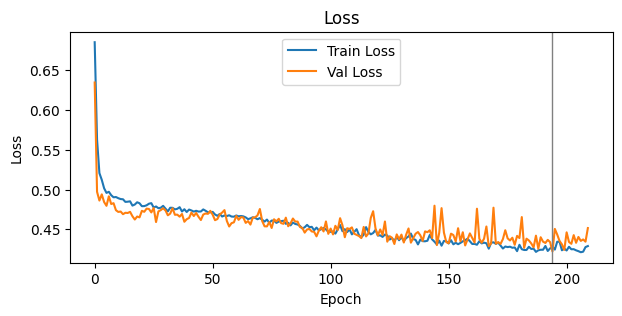

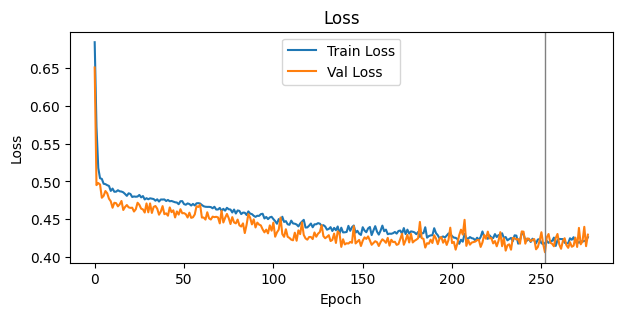

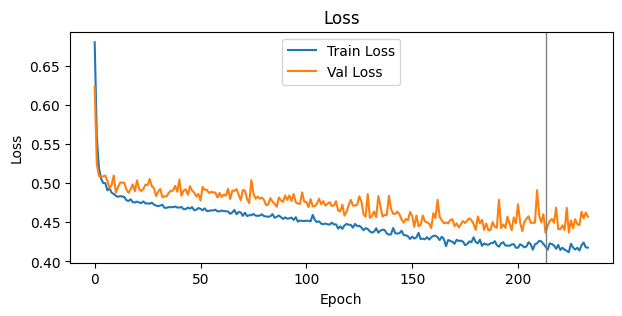

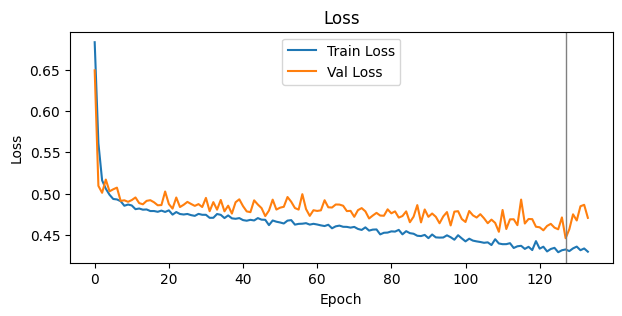

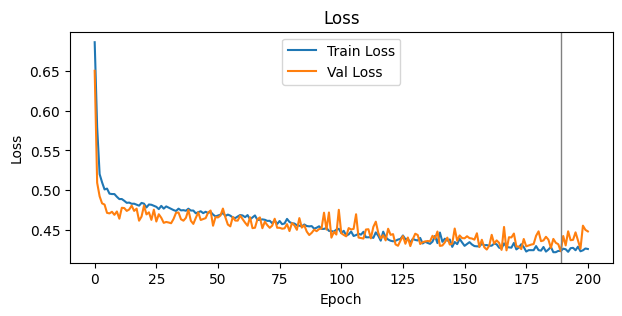

In [22]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(torch_dataset)):
    print(f'###### FOLD {fold} ######')
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    # Define data loaders for training and testing data specific to this fold
    train_loader = DataLoader(torch_dataset, batch_size=64, num_workers=os.cpu_count(), sampler=train_subsampler)
    val_loader = DataLoader(torch_dataset, batch_size=64, num_workers=os.cpu_count(), sampler=val_subsampler)

    model = get_model()
    optim = Adam(model.parameters())
    criterion = nn.BCELoss()

    training_loss, validation_loss = train_model(
        model, 
        criterion, 
        optim, 
        train_loader, 
        val_loader, 
        epochs=500, # very large number as we have implemented an early stop 
        patience=5, 
        min_delta=0.02, 
        checkpoint_path=f'./models_weights/model{fold}_weights.pt'
    )

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 3)
    ax.plot(training_loss, label='Train Loss')
    ax.plot(validation_loss, label='Val Loss')
    ax.axvline(validation_loss.index(min(validation_loss)), color='grey', linewidth=1)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_title('Loss')
    ax.legend()

### Final prediction and accuracy

In [29]:
t_X_test = torch.tensor(normalize(X_test, norm='l1'), dtype=torch.float)
torch_dataset_test = TensorDataset(t_X_test)
test_loader = DataLoader(torch_dataset_test, batch_size=64, num_workers=os.cpu_count(), shuffle=False)

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
preds = []

# Make predictions with each model and average them
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        mean_logps = []
        
        for i in range(5):
            model = get_model()
            model.load_state_dict(torch.load(f'./models_weights/model{i}_weights.pt'))
            model.to(device)
            model.eval()
            outputs = model(inputs)
            mean_logps.append(outputs)
            # free GPU memory
        
        mean_logp = torch.mean(torch.stack(mean_logps), dim=0)
        preds.extend((mean_logp >= 0.5).long().squeeze().tolist())

In [46]:
submission_df = pd.read_csv('sample_submission.csv', index_col='PassengerId')
submission_df['Transported'] = np.array(preds) > 0.5
submission_df.to_csv('MLP_submission.csv')

In [47]:
submission_df.head()

,Transported
PassengerId,
0013_01,False
0018_01,False
0019_01,True
0021_01,True
0023_01,True


Here is the final score for our cross validation MLP model : 
![MLP accuracy](./mlp_score.png)

Despite my best effort, I could not manage to beat the catboost classifier. Given that the catboost classifier is **way** faster and more performant than the MLP model, I will privilege the implementation of a catboost or xgboost model for this type of usecase.